In [1]:
from load_dataset.artgraph import ArtGraph
from utils.MultiTaskLinkSplitter import MultiTaskLinkSplitter
from utils.dataset import TrainingDataSet, TestDataSet
from utils.EarlyStopping import EarlyStopping
from multi_task_model import MultiTaskClassificationModel, NewMultiTaskClassificationModel
from torch import nn
from utils.training_utils import fine_tune, test as test_func, compute_topk, plot_confusion_matrix
from torch.utils.data import DataLoader
from torch import optim
import torch
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
%matplotlib inline

In [2]:
from torch_geometric.seed import seed_everything
seed_everything(1)

In [3]:
root = 'artgraph2bestemotions'
data_path = 'data_full_labels.csv'
root_dataset = 'common_dataset'

In [4]:
pos_neg_emotions = {8:2}
pos_neg_emotions.update({x:0 for x in (1, 2, 3, 5)})
pos_neg_emotions.update({x:1 for x in (0, 4, 6, 7)})

In [5]:
data = ArtGraph(root = root, preprocess='constant', features = 'vit', fine_tuning = True)[0]
data

Processing...
Done!


HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 342982] },
  (artwork, createdby, artist)={ edge_index=[2, 116475] },
  (artwork, elicit, emotion)={ edge_index=[2, 65236] },
  (artwork, hasgenre, genre)

In [7]:
emotion_value = data['emotion'].x[0].item()
data['emotion'].x = torch.full(size = (3, 1), fill_value = emotion_value)

emotion_entries = data['artwork', 'emotion'].edge_index[1].tolist()
data['artwork', 'emotion'].edge_index[1] = torch.Tensor(list(map(lambda x: pos_neg_emotions[x], emotion_entries)))
data

HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[3, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 342982] },
  (artwork, createdby, artist)={ edge_index=[2, 116475] },
  (artwork, elicit, emotion)={ edge_index=[2, 65236] },
  (artwork, hasgenre, genre)

mls = MultiTaskLinkSplitter(seed = 1)
train, val, test = mls.transform(data)
train

In [8]:
train = torch.load(f'{root_dataset}/train_data.pt')
val = torch.load(f'{root_dataset}/val_set.pt')
test = torch.load(f'{root_dataset}/test_set.pt')

In [9]:
train['emotion'].x = torch.full(size = (3, 1), fill_value = emotion_value)

emotion_entries = train['artwork', 'emotion'].edge_index[1].tolist()
train['artwork', 'emotion'].edge_index[1] = torch.Tensor(list(map(lambda x: pos_neg_emotions[x], emotion_entries)))


In [10]:
#loading data with labels
data_labels = pd.read_csv(data_path)
data_labels.emotion = data_labels.emotion.map(pos_neg_emotions)
data_labels.index = data_labels.artwork
data_labels['style'] -= 1
data_labels

,artwork,style,genre,emotion
artwork,,,,
81418,81418,0,4,1
28493,28493,2,9,0
28421,28421,2,3,2
28393,28393,2,9,2
28380,28380,2,9,1
...,...,...,...,...
71300,71300,9,6,2
68290,68290,22,6,2
68567,68567,22,6,2


In [11]:
train_dataset = TrainingDataSet(graph = train, data_labels = data_labels)

In [12]:
val_dataset = TestDataSet(graph = train, x_test = val, data_labels = data_labels)

In [13]:
test_dataset = TestDataSet(graph = train, x_test = test, data_labels = data_labels)

Test per vedere se va bene il modello pre-trained

In [14]:
device = torch.device('cuda:0')
genre_model = torch.load('genre.pt').to(device)
genre_model

ModelClassification(
  (encoder): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (decoder): Head(
    (head): Sequential(
      (0): Linear(in_features=2432, out_features=1216, bias=True)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=1216, out_features=608, bias=True)
      (4): LeakyReLU(negative_slope=0.1, inplace=True)
      (5): Dropout(p=0.25, inplace=False)
      (6): Linear(in_features=608, out_features=304, bias=True)
      (7): LeakyReLU(negative_slope=0.1, inplace=True)
      (8): Dropout(p=0.25, inplace=False)
      (9): Linear(in_features=304, out_features=152, bias=True)
      (10): LeakyReLU(negative_slope=0.1, inplace=True)
      (11): Dropout(p=0.25, inplace=False)
      (12): Linear(in_features=152, out_features=18, bias=True)
    )
  )
)

In [15]:
from tqdm import tqdm
device = torch.device('cuda:0')
train = train.to(device)

test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True, drop_last = False)
with torch.no_grad():
    running_corrects = 0 
    for _, images, (style_labels, genre_labels, emotion_labels) in tqdm(test_loader):
        images = images.to(device, non_blocking = True)
        genre_labels = genre_labels.to(device, non_blocking = True)
        genre_pred = genre_model(train.x_dict, train.edge_index_dict, images)
        running_corrects += torch.sum(torch.max(genre_pred, 1)[1] == genre_labels)
    print(f'Acc: {running_corrects/len(test_loader.dataset)}')

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:06<00:00,  7.71it/s]


Acc: 0.8140996694564819


## INSTANTIATING MODEL

In [16]:
device = torch.device('cuda:0')
style_encoder = torch.load('best_model_style_single_task.pt').encoder
genre_encoder = torch.load('best_model_genre_single_task.pt').encoder
emotion_encoder = torch.load('best_model_emotion_single_task_ternary.pt').encoder
model = NewMultiTaskClassificationModel(data = data, hidden_channels=None, head_num_layers=5,
                                        encoders = (style_encoder, genre_encoder, emotion_encoder)).to(device)
#model = MyModel(models = [style_encoder, genre_encoder, emotion_encoder]).to(device)

In [17]:
model

NewMultiTaskClassificationModel(
  (encoder_style): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (encoder_genre): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (encoder_emotion): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=6912, out_features=3456, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=3456, out_features=1728, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1728, out_features=864, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=864, out_features=432, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
  )
  (

for p in model.encoder_style.parameters():
    p.requires_grad = False
for p in model.encoder_genre.parameters():
    p.requires_grad = False
for p in model.encoder_emotion.parameters():
    p.requires_grad = False

In [18]:
from torch_geometric.transforms import ToUndirected
train = ToUndirected()(train).to(device)
with torch.no_grad():
    model.encoder_style(train.x_dict, train.edge_index_dict)
    model.encoder_genre(train.x_dict, train.edge_index_dict)
    model.encoder_emotion(train.x_dict, train.edge_index_dict)

In [19]:
batch_size = 128
num_epochs = 50
criterions = list(nn.CrossEntropyLoss() for _ in range(3))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop= EarlyStopping(patience = 5, min_delta = 1e-3, checkpoint_path = 'best_new_multitask_model_ternary.pt')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-7, verbose = True, factor = .5, patience = 1,
                                               threshold = 1e-4)
#fine_tune(model, train, train_loader, val_loader, criterions, optimizer, early_stop, scheduler, num_epochs)


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 20.09it/s]


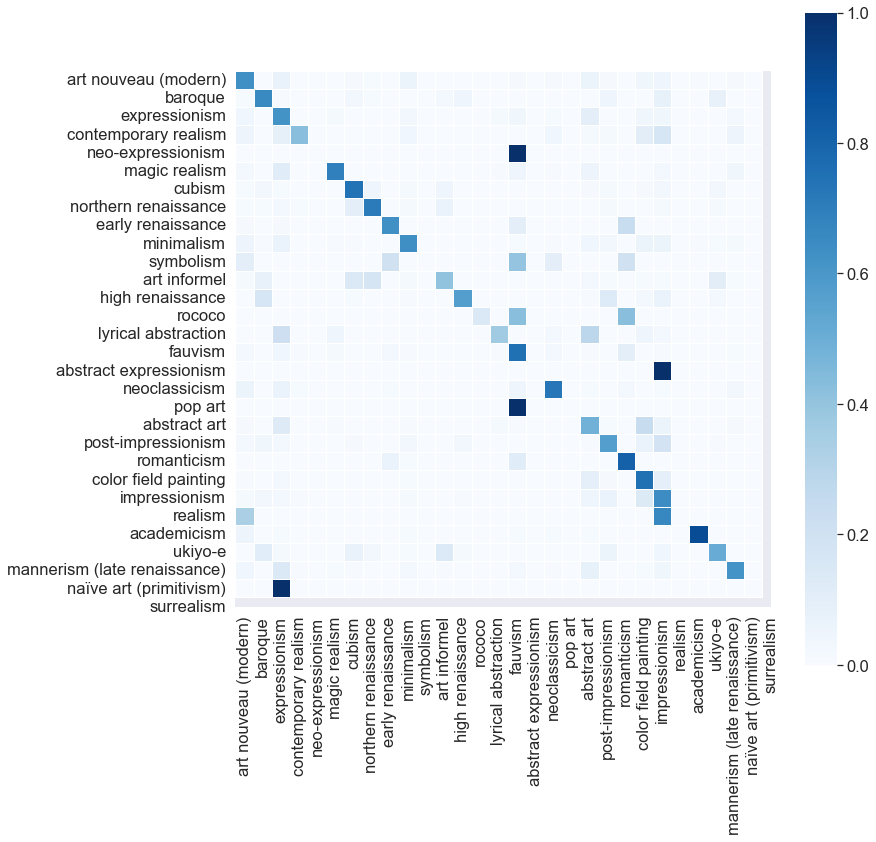

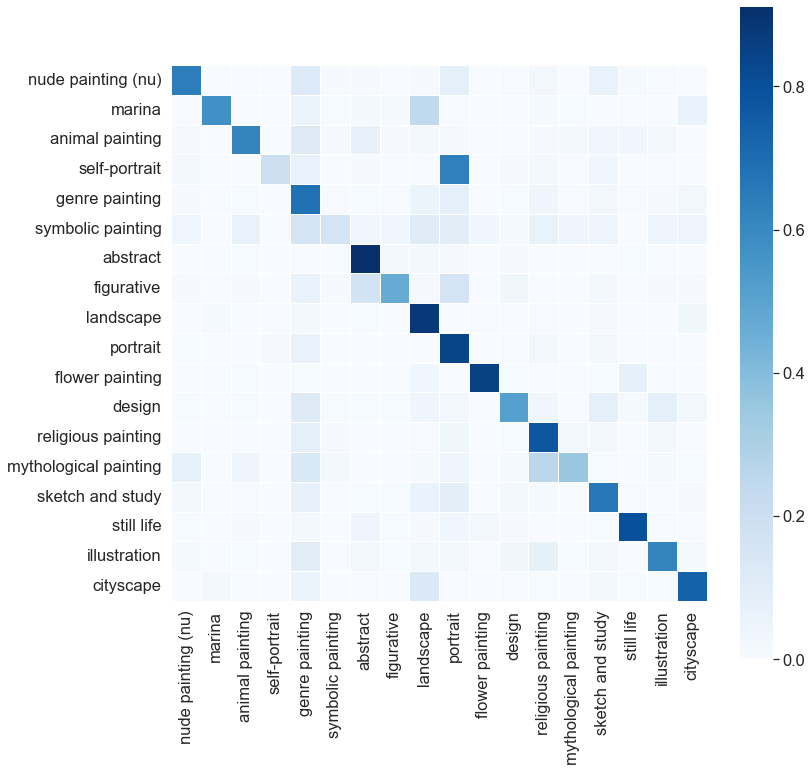

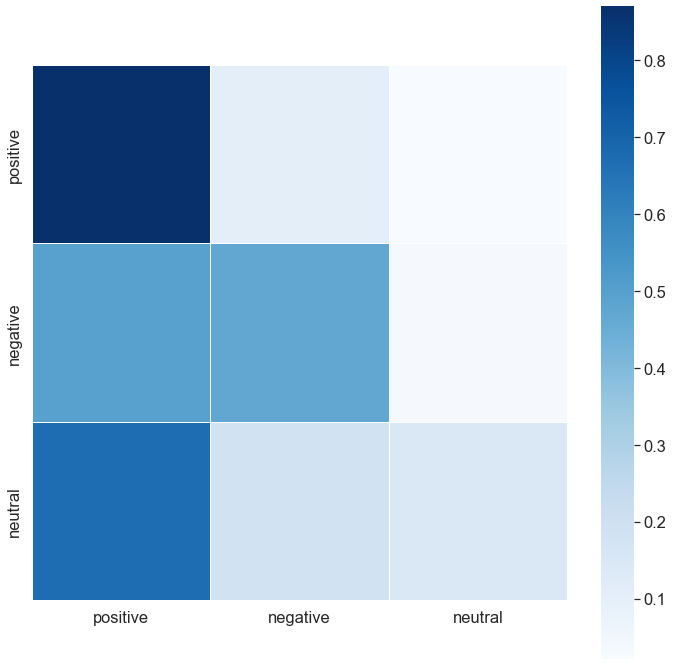

In [20]:
model = torch.load('best_new_multitask_model_ternary.pt').to('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':1}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    if task == 'emotion':
        labels = ['positive', 'negative', 'neutral']
    else:
        labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

In [21]:
results_df

,Top1,Top2,Macro-F1
style,0.642452,0.811341,0.492884
genre,0.752337,0.885364,0.640184
emotion,0.662069,0.879847,0.503952


In [22]:
results_df.to_csv('resuls_multi_task_ternary_fine_tuning.csv')

In [23]:
model = torch.load('best_new_multitask_model_ternary.pt').to('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':1}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train, update_graph=True)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    if task == 'emotion':
        labels = ['positive', 'negative', 'neutral']
    else:
        labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    #plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 26.33it/s]


In [24]:
results_df

,Top1,Top2,Macro-F1
style,0.642452,0.812107,0.492574
genre,0.75341,0.886284,0.641456
emotion,0.663142,0.88046,0.504491


In [25]:
results_df.to_csv('resuls_multi_task_ternary_fine_tuning_update.csv')

Test addestrando gli encoder da $0$

In [26]:
model = MultiTaskClassificationModel(data = train, hidden_channels = 128, head_num_layers = 5).to(device)
model

MultiTaskClassificationModel(
  (encoder): GraphModule(
    (convs): ModuleList(
      (0): ModuleDict(
        (artist__belongstofield__field): GATConv((-1, -1), 128, heads=1)
        (artist__belongstomovement__movement): GATConv((-1, -1), 128, heads=1)
        (artist__haspatron__people): GATConv((-1, -1), 128, heads=1)
        (artist__hassubject__subject): GATConv((-1, -1), 128, heads=1)
        (artist__relatedtoschool__training_node): GATConv((-1, -1), 128, heads=1)
        (artist__trainedby__artist): GATConv((-1, -1), 128, heads=1)
        (artwork__about__tag): GATConv((-1, -1), 128, heads=1)
        (artwork__createdby__artist): GATConv((-1, -1), 128, heads=1)
        (artwork__elicit__emotion): GATConv((-1, -1), 128, heads=1)
        (artwork__hasgenre__genre): GATConv((-1, -1), 128, heads=1)
        (artwork__hasperiod__period): GATConv((-1, -1), 128, heads=1)
        (artwork__hasstyle__style): GATConv((-1, -1), 128, heads=1)
        (artwork__locatedin__city): GATConv((-

In [27]:
from torch_geometric.transforms import ToUndirected
train = ToUndirected()(train).to(device)
with torch.no_grad():
    model.encoder(train.x_dict, train.edge_index_dict)

In [28]:
batch_size = 128
num_epochs = 50
criterions = list(nn.CrossEntropyLoss() for _ in range(3))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop= EarlyStopping(patience = 5, min_delta = 1e-3, checkpoint_path = 'best_multitask_model_ternary.pt')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-7, verbose = True, factor = .5, patience = 1,
                                               threshold = 1e-4)
#fine_tune(model, train, train_loader, val_loader, criterions, optimizer, early_stop, scheduler, num_epochs)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:06<00:00,  7.33it/s]


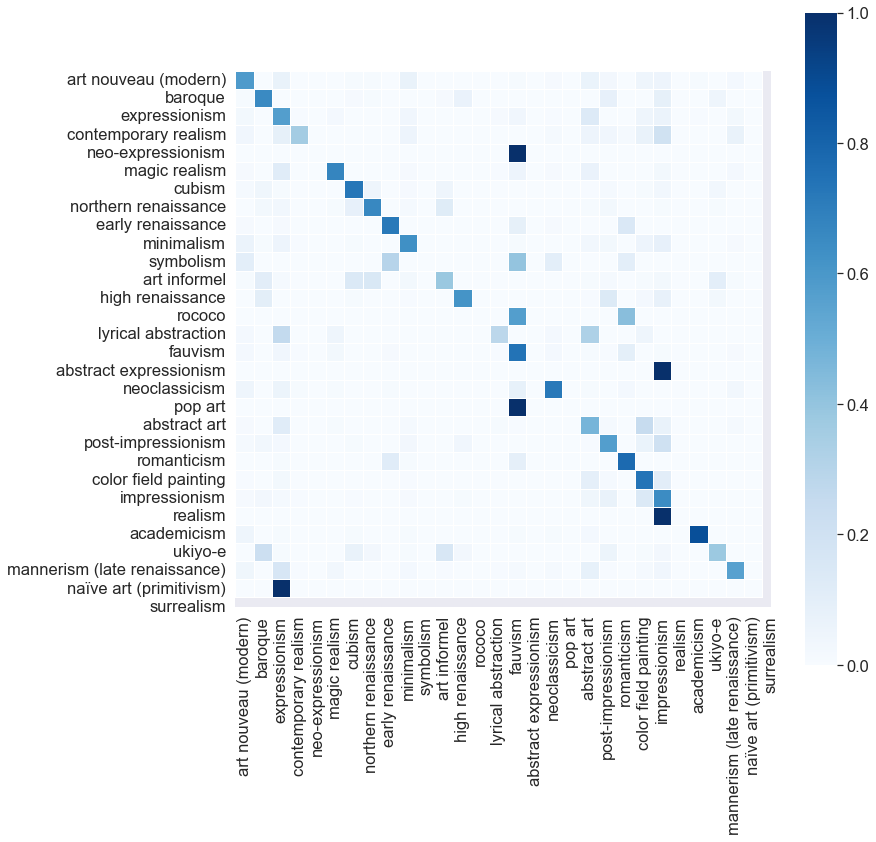

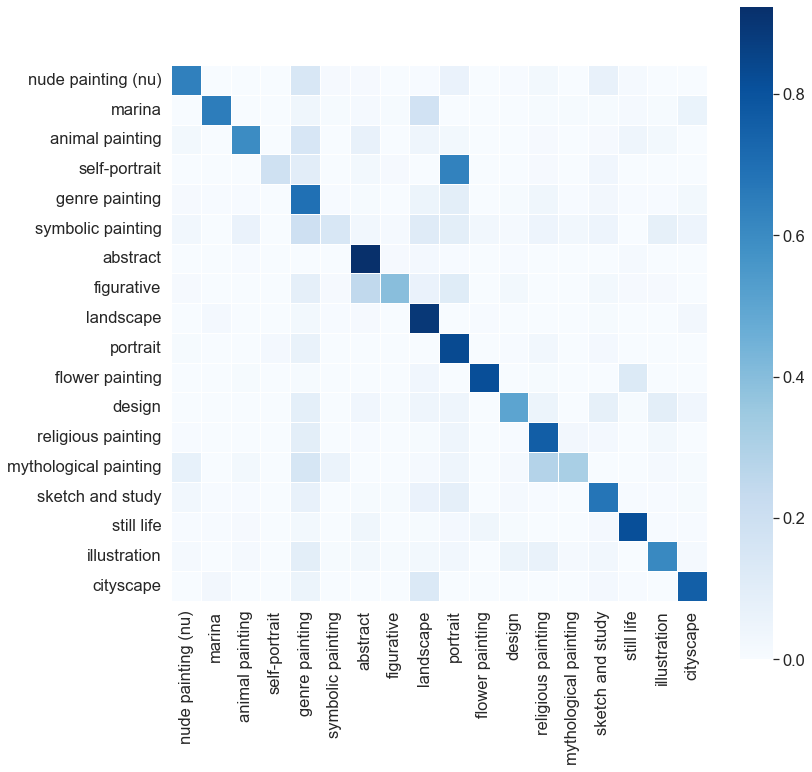

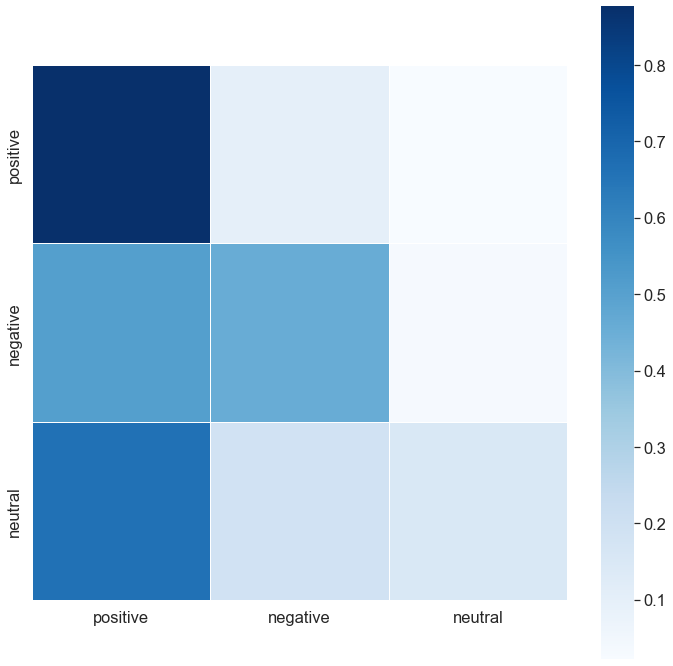

In [29]:
model = torch.load('best_multitask_model_ternary.pt').to('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    if task == 'emotion':
        labels = ['positive', 'negative', 'neutral']
    else:
        labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

In [30]:
results_df

,Top1,Top2,Macro-F1
style,0.626054,0.802759,0.468318
genre,0.754176,0.88659,0.637212
emotion,0.663295,0.879387,0.504392


In [31]:
results_df.to_csv('resuls_multi_task_ternary_scratch.csv')

In [32]:
model = torch.load('best_multitask_model_ternary.pt').to('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train, update_graph=True)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    if task == 'emotion':
        labels = ['positive', 'negative', 'neutral']
    else:
        labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    #plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:06<00:00,  7.36it/s]


In [33]:
results_df

,Top1,Top2,Macro-F1
style,0.62636,0.801379,0.468756
genre,0.753716,0.886743,0.636313
emotion,0.662835,0.879234,0.503792


In [34]:
results_df.to_csv('resuls_multi_task_ternary_scratch_update.csv')